\subsection{Data Preprocessing}

We try to follow the paper which uses transformed SPX option prices as features to predict 30-day SPX realized variances. The motivation behind this idea is that, VIX squared is usually used by the practitioners to predict the 30-day realized variances of SPX. Since, by definition, VIX squared is close to a weighted sum of the transformed SPX option prices, it is natural to ask if machine learning algorithms can do a better job than a simple weighted sum. 

Specifically, VIX is defined as
\begin{eqnarray}
VIX = 100\sqrt{T_1\sigma_1^2\left(\frac{T_2-T_{30}}{T_2-T_{1}}\right) + T_2\sigma_2^2\left(\frac{T_{30}-T_1}{T_2-T_{1}}\right)},  \label{eq:vix}
\end{eqnarray}
where 
\begin{eqnarray*}
\sigma_1^2 &=& \frac{2}{T_1}\sum_h \frac{\Delta K_h}{K_h^2} e^{R_1T_1} O(K_h, T_1) - \frac{1}{T_1}\left(\frac{F}{K_0} - 1\right)^2,\\
\sigma_2^2 &=& \frac{2}{T_2}\sum_h \frac{\Delta K_h}{K_h^2} e^{R_2T_2} O(K_h, T_2) - \frac{1}{T_2}\left(\frac{F}{K_0} - 1\right)^2, 
\end{eqnarray*}
$F$ is the current 30-day forward value of the SPX index, $K_0$ is the current at-the-money (ATM) strike, $K_h$'s are the out-of-the-money (OTM) strikes, $\Delta K_h = K_{h+1} - K_h$ is the difference between two adjacent strikes, $O(K_h, T)$ is the price of the option with expiry $T$ at strike $K_h$, $T_{30}$ is 30 days from now, $T_1$ and $T_2$ are the closest trading expiries around $T_{30}$, and $R_1$ and $R_2$ are the corresponding interest rates. Eq. (\ref{eq:vix}) states that $(VIX/100)^2$ is an interpolation of $\sigma_1^2T_1$ and $\sigma_2^2T_2$, which are the implied variances of the index at time $T_1$ and $T_2$, respectively. This interpolation step is needed because most of the time there are no trading options which expire at exactly $T_{30}$. When there actually are, the VIX formula reduces to 
\begin{eqnarray*}
VIX = 100\sqrt{T_{30}\sigma_{30}^2}, 
\end{eqnarray*}
with
\begin{eqnarray*}
\sigma_{30}^2 &=& \frac{2}{T_{30}}\sum_h \frac{\Delta K_h}{K_h^2} e^{R_{30}T_{30}} O(K_h, T_{30}). 
\end{eqnarray*}
Note that in this case the $-\left(F/K_0 - 1\right)^2/T_{30}$ term vanishes because the put call parity guarantees $F=K_0$. This reduced form of the VIX formula can be further rewritten as 
\begin{eqnarray}
(VIX/100)^2 = \sum_h 2\Delta K_he^{R_{30}T_{30}} \frac{O(K_h, T_{30})}{K_h^2}, \label{eq:vix_squared}
\end{eqnarray}
which is a weighted sum of $O(K_h, T_{30})/K_h^2$. 


The left hand side expression of Eq. (\ref{eq:vix_squared}), $(VIX/100)^2$, is usually used in practice as an estimator of the 30-day realized variances of the index. When $T_{30}$ options are not trading, the formula of $(VIX/100)^2$ will be slightly more complicated, but it is still a weighted sum of the transformed option prices $O(K_h, T_{1})/K_h^2$ and $O(K_h, T_{2})/K_h^2$, plus the forward terms $-\left(F/K_0 - 1\right)^2/T_{1}$ and $-\left(F/K_0 - 1\right)^2/T_{2}$, which are usually small and can be ignored. 



We were able to get the SPX implied volatility data since 2005 from Bloomberg, which we use to back out the option prices. Since any point on the volatility surfaces can be queried, we simply take the implied volatilities of the $T_{30}$ options, saving the interpolation step. For moneyness control, the Bloomberg API only takes the option Delta. We take the implied volatilities of the options whose Delta are $\pm 10\%, \pm 25\%$ and $\pm 40\%$ (positive for call and negative for put options), and the ATM implied volatilities (corresponding to $+50\%$ Delta call options or equivalently $-50\%$ Delta put options), overall 7 OTM strikes. We obtain these implied volatilities on every business date since 2005/1/1 and plug into the Black-Scholes formula to compute the option prices. For interest rates needed to apply the Black-Scholes formula, we obtain the 1 month LIBOR rate from Bloomberg. 


According to CBOE's definition of VIX, the number of terms in the summation formula in $\sigma_i^2$ depends on the liquidity of the $T_i$ options




In [1]:
from scipy.stats import norm
from pandas import DataFrame
import numpy as np
import pandas as pd

def bsCall(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
def bsPut(S, K, r, s, T):
    d1 = (np.log(S/K) + (r + 0.5*s**2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    return -S*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)

vol = pd.read_csv('IV.csv', parse_dates=['Date']).iloc[1:, :].set_index('Date').dropna()
spx = pd.read_csv('data.csv', parse_dates=['Date'])[['Date', 'SPX']].set_index('Date')
param = pd.read_csv('LIBOR.csv', header=5, parse_dates=[0]).iloc[:, :2].set_index('Date').rename(columns={'PX_ASK': '1ML'}).merge(spx, on='Date')

dates = param.index.intersection(vol.index)
param = param.loc[dates]
param = param.assign(FWD=np.exp(param['1ML']/1200)*param['SPX'])
vol = vol.loc[dates]

param.index = vol.index
strike = DataFrame(np.array([param['FWD'] + Delta for Delta in [-90, -75, -60, -50, -40, -25, -10, 0, 10, 25, 40, 50, 60, 75, 90]]).T, 
                  columns=vol.columns, index=vol.index)

In [5]:
%%time

m, n = vol.shape
pv = np.empty_like(vol)
for i in range(m):
    for j in range(n):
        pricingFnc = bsCall if vol.columns[j][0] == 'C' else bsPut
        pv[i, j] = pricingFnc(  S=param['SPX'].iloc[i], 
                                K=strike.iloc[i, j], 
                                r=param['1ML'].iloc[i]/100, 
                                s=vol.iloc[i, j]/100, 
                                T=1/12)            
        
pv = DataFrame(pv, columns=vol.columns, index=vol.index)
pv.to_csv('pv.csv')

CPU times: user 23.5 s, sys: 44.8 ms, total: 23.6 s
Wall time: 25.9 s


In [2]:
from sklearn.preprocessing import StandardScaler

pv = pd.read_csv('pv.csv', index_col=0)
pv.index = strike.index

DataFrame(StandardScaler().fit_transform(pv/(strike**2)), index=pv.index, columns=pv.columns).to_csv('features.csv')

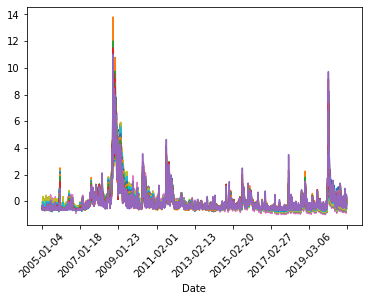

In [3]:
df = pd.read_csv('features.csv', index_col=0)

df.plot(rot=45, legend=None)
pass

In [4]:
df.describe().loc[['mean', 'std']]

,PUT_90,PUT_75,PUT_60,PUT_50,PUT_40,PUT_25,PUT_10,ATM,CALL_10,CALL_25,CALL_40,CALL_50,CALL_60,CALL_75,CALL_90
mean,9.962542e-17,-2.846441e-17,-4.269661e-17,5.692881e-17,-5.692881e-17,-5.692881e-17,5.692881e-17,-2.277152e-16,-2.846441e-17,8.539322e-17,1.423220e-16,-8.539322e-17,-5.692881e-17,-1.138576e-16,-4.269661e-17
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00


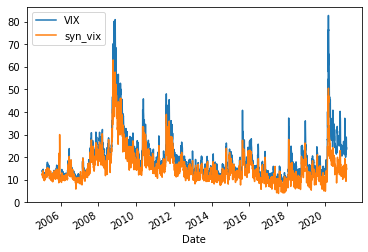

In [5]:
vix = pd.read_csv('data.csv', parse_dates=['Date'])[['Date', 'VIX']].set_index('Date').loc[vol.index]
Delta = [-90, -75, -60, -50, -40, -25, -10, 0, 10, 25, 40, 50, 60, 75, 90]
dK = [15.] + [(kp-km)/2 for kp, km in zip(Delta[2:], Delta[:-2])] + [15.]
vix = vix.assign(syn_vix=100*np.sqrt(2*((dK/(strike**2))*pv).sum(axis='columns')*np.exp(param['1ML']/1200)/(1/12)).values)
vix.to_csv('vix.csv')

vix.plot()
pass